<a href="https://colab.research.google.com/github/VedantZope/Plant-Pathology-FGVC7-Dataset/blob/main/Plant_Pathology_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install ray[tune]

     |████████████████████████████████| 49.6 MB 6.0 kB/s 
     |████████████████████████████████| 72 kB 489 kB/s 
     |████████████████████████████████| 124 kB 35.6 MB/s 


In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import numpy as np
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
np.random.randint(2, 9)

4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data_path = '/content/drive/MyDrive/plant-pathology-2020-fgvc7/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')


In [ ]:
! mkdir /content/drive/MyDrive/plant-pathology-2020-fgvc7/train

mkdir: cannot create directory ‘/content/drive/MyDrive/plant-pathology-2020-fgvc7/train’: File exists


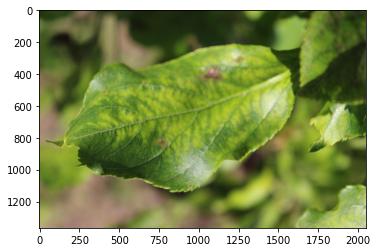

In [ ]:
import cv2
img_path = f'/content/drive/MyDrive/plant-pathology-2020-fgvc7/validation/scab/'
image = cv2.imread(img_path + 'Train_0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)


In [ ]:
images = f'/content/drive/MyDrive/plant-pathology-2020-fgvc7/'
#train_labels = f'/content/drive/MyDrive/plant-pathology-2020-fgvc7/train.csv'

In [ ]:
import shutil
# for i in range(len(train)):
#   image = cv2.imread(images + str(train['image_id'][i]) + '.jpg')
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   break

def create_dataset(file):
  for i in range(len(file)):
    img_path = images + str(file['image_id'][i]) + '.jpg'
    image_id = file['image_id'][i]
    if file['healthy'][i] == 1:
      shutil.move(img_path, '/content/drive/MyDrive/plant-pathology-2020-fgvc7/train/healthy')
    if file['multiple_diseases'][i] == 1:
      shutil.move(img_path, '/content/drive/MyDrive/plant-pathology-2020-fgvc7/train/multiple_diseases')
    if file['rust'][i] == 1:
      shutil.move(img_path, '/content/drive/MyDrive/plant-pathology-2020-fgvc7/train/rust')
    if file['scab'][i] == 1:
      shutil.move(img_path, '/content/drive/MyDrive/plant-pathology-2020-fgvc7/train/scab')


def create_testset(file):
  for i in range(len(file)):
    img_path = str(images + file['image_id'][i] + '.jpg')
    shutil.move(img_path, '/content/drive/MyDrive/plant-pathology-2020-fgvc7/test/all')




  

In [ ]:
from torchvision import transforms
from torchvision import datasets

In [ ]:
#tried to use shuf and xargs but not serving the purpose

In [ ]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
      ])
val_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_ds = datasets.ImageFolder('/content/drive/MyDrive/plant-pathology-2020-fgvc7/train', transform=train_transforms)
val_ds = datasets.ImageFolder('/content/drive/MyDrive/plant-pathology-2020-fgvc7/validation', transform=val_transforms)
test_ds = datasets.ImageFolder('/content/drive/MyDrive/plant-pathology-2020-fgvc7/test', transform=val_transforms)

In [ ]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)

In [ ]:
batch_size_test = 3
test_dl = DataLoader(test_ds, batch_size_test, shuffle=False)

In [ ]:
from torchvision import models

In [ ]:
#model = models.vgg16(pretrained=True)
model = models.resnet50(pretrained=True)
for parameters in model.parameters():
  parameters.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# model.classifier[6] = nn.Sequential(
#                           nn.Linear(4096, 256),        #4096 is the no of parameters in VGG-16 here
#                           nn.ReLU(),
#                           nn.Dropout(0.4),
#                           nn.Linear(256, 4),
#                           nn.LogSoftmax(dim=1)
#)

In [ ]:
model.fc = nn.Sequential(
                    nn.Linear(2048, 128),
                    nn.ReLU(),
                    nn.Dropout(0.4),
                    nn.Linear(128, 4),
                    nn.LogSoftmax(dim=1)                   
)

In [ ]:
model.to('cuda')
#model = nn.DataParallel(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def accuracy(inputs, labels):
  _, pred = torch.max(inputs, dim=1)
  matches = torch.sum(pred.cuda() == labels.cuda()).item()/len(pred)
  return matches 


In [ ]:
! pip install torchmetrics

     |████████████████████████████████| 282 kB 5.5 MB/s 


In [ ]:
import torchmetrics
from torchmetrics import AUROC 


In [ ]:
def calc_auroc(inputs, labels):
  target = torch.reshape(labels, [235])
  preds = torch.reshape(inputs, (235, 4))
  auroc = AUROC(num_classes=4)
  arc = auroc(preds, target)
  print(arc)

In [ ]:
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:

import tensorflow_addons as tfa

In [ ]:
#custom loss func for imbalanced dataset
import math
def cust_loss_func(b, alpha, gamma, pred, label):
  ce_loss = F.cross_entropy(pred, label, reduction= "mean", weight= torch.tensor([b*math.log(235/60), b*math.log(235/20), b*math.log(235/80) , b*math.log(235/75)], device= 'cuda'))
  ce_loss = F.cross_entropy(pred, label, reduction= 'mean')
  pt = torch.exp(-ce_loss)
  focal_loss = (alpha*(1 - pt) ** gamma * ce_loss).mean()
  return ce_loss

In [ ]:
import torch.nn.functional as F
def train(config):
  #loss_func = nn.NLLLoss()
  #loss_func = torch.optim.SGD()
  optim_func = torch.optim.Adam
  #optim_func = torch.optim.SGD
  optimizer = optim_func(model.parameters(), lr= config["lr"], weight_decay= config["weight_decay"])
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=10, steps_per_epoch=len(train_dl))
  #scheduler = torch.optim.lr_scheduler.  
  num_epochs = 15
  #lr = 5e-5
  train_loss = []
  val_loss = []
  val_acc = []
  b = config["b"]
  for i in range(num_epochs):
    model.train()
    predictions = []
    labels = []
    for batch, label in train_dl:
      optimizer.zero_grad()
      output = model(batch.cuda())
      loss = cust_loss_func(b,0.2, 2, output.cuda(), label.cuda())
      train_loss.append(loss)
      loss.backward()
      optimizer.step()
    #scheduler.step()
    print("Train_Loss = " + str(sum(train_loss)/len(train_loss)))
    model.eval()
    with torch.no_grad():
      for batch , label in val_dl:
        output = model(batch.cuda())
        predictions.append(output)
        labels.append(label)
        loss = cust_loss_func(b, 0.2, 2, output.cuda(), label.cuda())
        val_loss.append(loss)
        acc = accuracy(output.cuda(), label.cuda())
        val_acc.append(acc)
    print("Val_Loss = " + str(sum(val_loss)/len(val_loss)))
    print("Val_Accuracy = " + str(sum(val_acc)/len(val_acc)))
    predictions_ = torch.stack(predictions)
    labels_ = torch.stack(labels)
    calc_auroc(predictions_.cuda(), labels_.cuda())
    print(" Training_Loss = " + str(sum(train_loss)/len(train_loss)), " Validation_Loss = " + str(sum(val_loss)/len(val_loss)))

In [ ]:
config_trial = {
    "b" : 3.07,
    "lr" : 6e-4,
    "weight_decay" : 1e-4
}

In [ ]:
train(config_trial)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(pid=2804) Train_Loss = tensor(1.1560, device='cuda:0', grad_fn=<DivBackward0>)
(pid=2804) Val_Loss = tensor(1.0661, device='cuda:0')
(pid=2804) Val_Accuracy = 0.7617021276595739
(pid=2804) tensor(0.8994, device='cuda:0')
(pid=2804)  Training_Loss = tensor(1.1560, device='cuda:0', grad_fn=<DivBackward0>)  Validation_Loss = tensor(1.0661, device='cuda:0')
Train_Loss = tensor(1.2101, device='cuda:0', grad_fn=<DivBackward0>)
Val_Loss = tensor(1.0797, device='cuda:0')
Val_Accuracy = 0.5829787234042555
tensor(0.8892, device='cuda:0')
 Training_Loss = tensor(1.2101, device='cuda:0', grad_fn=<DivBackward0>)  Validation_Loss = tensor(1.0797, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


(pid=2804) Train_Loss = tensor(1.1003, device='cuda:0', grad_fn=<DivBackward0>)
(pid=2804) Val_Loss = tensor(1.0010, device='cuda:0')
(pid=2804) Val_Accuracy = 0.7617021276595736
(pid=2804) tensor(0.9044, device='cuda:0')
(pid=2804)  Training_Loss = tensor(1.1003, device='cuda:0', grad_fn=<DivBackward0>)  Validation_Loss = tensor(1.0010, device='cuda:0')
Train_Loss = tensor(1.1344, device='cuda:0', grad_fn=<DivBackward0>)
Val_Loss = tensor(0.9604, device='cuda:0')
Val_Accuracy = 0.6808510638297869
tensor(0.9048, device='cuda:0')
 Training_Loss = tensor(1.1344, device='cuda:0', grad_fn=<DivBackward0>)  Validation_Loss = tensor(0.9604, device='cuda:0')
(pid=2804) Train_Loss = tensor(1.0660, device='cuda:0', grad_fn=<DivBackward0>)
(pid=2804) Val_Loss = tensor(0.9568, device='cuda:0')
(pid=2804) Val_Accuracy = 0.7712765957446804
(pid=2804) tensor(0.9201, device='cuda:0')
(pid=2804)  Training_Loss = tensor(1.0660, device='cuda:0', grad_fn=<DivBackward0>)  Validation_Loss = tensor(0.9568, d

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "lr" : tune.loguniform(5e-5, 1e-1),
        "b" : tune.sample_from(lambda _ : np.random.uniform(1.0, 4.0)),
        "weight_decay" : tune.loguniform(1e-5, 1e-3)
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        run_or_experiment = train,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=1)

(pid=2681) 2021-09-24 12:34:11,648	ERROR worker.py:428 -- SystemExit was raised from the worker
(pid=2681) Traceback (most recent call last):
(pid=2681)   File "python/ray/_raylet.pyx", line 640, in ray._raylet.task_execution_handler
(pid=2681)   File "python/ray/_raylet.pyx", line 488, in ray._raylet.execute_task
(pid=2681)   File "python/ray/_raylet.pyx", line 525, in ray._raylet.execute_task
(pid=2681)   File "python/ray/_raylet.pyx", line 532, in ray._raylet.execute_task
(pid=2681)   File "python/ray/_raylet.pyx", line 536, in ray._raylet.execute_task
(pid=2681)   File "python/ray/_raylet.pyx", line 486, in ray._raylet.execute_task.function_executor
(pid=2681)   File "/usr/local/lib/python3.7/dist-packages/ray/_private/function_manager.py", line 563, in actor_method_executor
(pid=2681)     return method(__ray_actor, *args, **kwargs)
(pid=2681)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable.py", line 178, in train_buffered
(pid=2681)     result = self.train()
(pid

== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/train_2021-09-24_12-33-59
Number of trials: 10/10 (10 PENDING)
+-------------------+----------+-------+---------+-------------+----------------+
| Trial name        | status   | loc   |       b |          lr |   weight_decay |
|-------------------+----------+-------+---------+-------------+----------------|
| train_b1f27_00000 | PENDING  |       | 3.84614 | 9.61532e-05 |    2.24305e-05 |
| train_b1f27_00001 | PENDING  |       | 2.40026 | 5.28728e-05 |    0.000429683 |
| train_b1f27_00002 | PENDING  |       | 3.55007 | 0.0802378   |    6.28401e-05 |
| train_b1f27_00003 | PENDING  |       | 3.68778 | 0.000639658 |    2.06716e-05 |
| train_b1f27_00004 | PENDING  |       | 2.855

2021-09-24 12:34:14,295	WARNING worker.py:1215 -- Warning: The actor ImplicitFunc is very large (91 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2021-09-24 12:34:14,422	WARNING util.py:164 -- The `start_trial` operation took 1.725 s, which may be a performance bottleneck.
2021-09-24 12:34:15,478	WARNING util.py:164 -- The `start_trial` operation took 1.047 s, which may be a performance bottleneck.
2021-09-24 12:34:16,482	WARNING util.py:164 -- The `start_trial` operation took 0.893 s, which may be a performance bottleneck.
2021-09-24 12:34:17,480	WARNING util.py:164 -- The `start_trial` operation took 0.887 s, which may be a performance bottleneck.
2021-09-24 12:34:18,411	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 3.7/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.33 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/train_2021-09-24_12-33-59
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+-------+---------+-------------+----------------+
| Trial name        | status   | loc   |       b |          lr |   weight_decay |
|-------------------+----------+-------+---------+-------------+----------------|
| train_b1f27_00000 | RUNNING  |       | 3.84614 | 9.61532e-05 |    2.24305e-05 |
| train_b1f27_00001 | PENDING  |       | 2.40026 | 5.28728e-05 |    0.000429683 |
| train_b1f27_00002 | PENDING  |       | 3.55007 | 0.0802378   |    6.28401e-05 |
| train_b1f27_00003 | PENDING  |       | 3.68778 | 0.000639658 |    2.06716e-05 |
| train_b1f27_00004 | PENDING  |

2021-09-24 12:34:19,383	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.
2021-09-24 12:34:20,322	WARNING util.py:164 -- The `start_trial` operation took 0.830 s, which may be a performance bottleneck.
2021-09-24 12:34:21,257	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.
2021-09-24 12:34:22,216	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.
(pid=2804) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=2804)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-09-24 12:35:28,238	WARNING tune.py:519 -- SIGINT received

KeyboardInterrupt: ignored

In [ ]:
_, preds = torch.max(torch.reshape(predictions_, (235, 4)), dim= 1)
labels_cm = torch.reshape(labels_, [235])

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds.cpu(), labels_cm.cpu())

In [ ]:
cm_df = pd.DataFrame(cm, index= ['Healthy', 'Multiple Diseases', 'Rust', 'Scab'], columns= ['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.show()

In [ ]:
print(predictions_)
preds = torch.reshape(predictions_, (235, 4))
preds 

In [ ]:

lab = torch.reshape(labels_, [235])
lab

In [ ]:
#Test Set Predictions
import csv
pred_test = []
i = 1
for batch, _ in test_dl:
  output = model(batch.cuda())
  _, pred = torch.max(output, dim = 1)
  pred_test.append(pred)
  i+=1
pred_test_all = torch.stack(pred_test, dim=1)
pred_test_final = torch.reshape(pred_test_all, [1821])

In [ ]:
test["pred"] = pred_test_final.cpu()
test["healthy"] = test.apply(lambda x : 1 if x["pred"] == 0 else 0, axis = 1)
test["multiple_diseases"] = test.apply(lambda x : 1 if x["pred"] == 1 else 0, axis = 1)
test["rust"] = test.apply(lambda x : 1 if x["pred"] == 2 else 0, axis = 1)
test["scab"] = test.apply(lambda x : 1 if x["pred"] == 3 else 0, axis = 1)
test = test.drop(columns= ["pred"])
test.to_csv("submission.csv", index= False)  
